In [1]:
import os
from pathlib import Path

script_dir = Path.cwd().parent

In [ ]:
from typing import List, TypedDict, Literal, Optional
from datetime import datetime
from langgraph.graph import StateGraph, START, END
from trafilatura import fetch_url, extract
import requests
import json
from together import Together
from pydantic import BaseModel, Field
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv('../studio/.env')

model = ChatOpenAI(model="gpt-4o", temperature=0) 
client = Together()

╭───────────────────────────────────────────── 🚀 New SDK Available ──────────────────────────────────────────────╮
│ Together Python SDK 2.0 is now available!                                                                       │
│                                                                                                                 │
│ Install the beta:                                                                                               │
│ pip install --pre together  or  uv add together --prerelease allow                                              │
│                                                                                                                 │
│ New SDK: ]8;id=554030;https://github.com/togethercomputer/together-py\https://github.com/togethercomputer/together-py]8;;\                                                        │
│ Migration guide: ]8;id=414524;https://docs.together.ai/docs/pythonv2-migration-guide\https://docs.together.ai/docs/pythonv2-migration-guide]8;;\                                         │
│                                                                                                                 │
│ This package will be maintained until January 2026.                                                             │
│ Set TOGETHER_NO_BANNER=1 to hide this message.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
class Author(BaseModel):
    first_name: str = Field(description="The author's first name")
    middle_name: str = Field(description="The author's middle name (can be empty string if not available)")
    last_name: str = Field(description="The author's last name")

class CitationData(BaseModel):
    authors: List[Author] = Field(
        description="A list of authors for the article"
    )
    article_title: str = Field(
        description="The headline or title of the article/page"
    )
    site_name: str = Field(
        description="The name of the website or publication"
    )
    publisher: str = Field(
        description="The organization publishing the site (often same as site name)"
    )
    pub_year: int = Field(
        description="The year of publication as an integer"
    )
    pub_date_formatted: str = Field(
        description="The publication date formatted for the citation style (e.g., '2023, May 12')"
    )

In [ ]:
class State(TypedDict):
    citation_style: Literal['apa_7', 'mla_9', 'chicago_17', 'ieee', 'harvard']
    url: str
    raw_website_output: Optional[str] = None
    citation_data: Optional[CitationData] = None
    finalized_citation: Optional[str] = None
    date_accessed: Optional[str] = datetime.now().strftime("%Y-%m-%d")


#url to use = https://www.britannica.com/event/2010-Haiti-earthquake

In [5]:
def get_website_data(state: State):
    downloaded = fetch_url(state["url"])
    result = extract(downloaded, with_metadata=True)
    return {"raw_website_output": result}


def extract_citation_data(state: State):
    prompt_path = script_dir / "prompts" / "citation_extraction.txt"
    with open(prompt_path, 'r') as f:
        prompt = f.read()
    
    formatted_prompt = prompt.format(extracted_website_data=state["raw_website_output"], json_format=str(json.dumps(CitationData.model_json_schema())))
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": formatted_prompt},
        ],
        model="Qwen/Qwen3-Next-80B-A3B-Instruct",
        response_format={
            "type": "json_schema",
            "schema": CitationData.model_json_schema(),
        },
    )
    output = json.loads(response.choices[0].message.content)
    return {"citation_data": output}

def finalize_citation(state: State):
    citation_styles_path = script_dir / "public" / "citation_styles.json"
    with open(citation_styles_path, 'r') as f:
        json_data = json.load(f)
    citation_styles = json_data["citation_styles"]
    citation_style_data = json.dumps(next((style for style in citation_styles if style["id"] == state["citation_style"]), None))

    prompt_path = script_dir / "prompts" / "finalize_citation.txt"

    with open(prompt_path, 'r') as f:
        prompt = f.read()
    
    formatted_prompt = prompt.format(
        citation_style_guide=citation_style_data,
        citation_data=state["citation_data"],
        url=state["url"],
        date_accessed=state["date_accessed"],
    )

    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": formatted_prompt},
        ],
        model="Qwen/Qwen3-Next-80B-A3B-Instruct")
    
    return {"finalized_citation": response.choices[0].message.content}
    
    


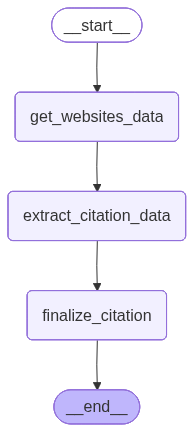

In [6]:
workflow = StateGraph(State)
workflow.add_node("get_websites_data", get_website_data)
workflow.add_node("extract_citation_data", extract_citation_data)
workflow.add_node("finalize_citation", finalize_citation)

workflow.add_edge(START, "get_websites_data")
workflow.add_edge("get_websites_data", "extract_citation_data")
workflow.add_edge("extract_citation_data", "finalize_citation")
workflow.add_edge("finalize_citation", END)


graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
class InputState(TypedDict):
    citation_style: Literal['apa_7', 'mla_9', 'chicago_17', 'ieee', 'harvard']
    url: str

formatted_today_date = datetime.now().strftime("%B %d, %Y")
graph.invoke({"url": "https://www.britannica.com/event/2010-Haiti-earthquake", "citation_style": "apa_7", "date_accessed": formatted_today_date})


{'citation_style': 'apa_7',
 'url': 'https://www.britannica.com/event/2010-Haiti-earthquake',
 'raw_website_output': "---\ntitle: 2010 Haiti earthquake | Magnitude, Damage, Map, & Facts | Britannica\nauthor: Richard Pallardy\nurl: https://www.britannica.com/event/2010-Haiti-earthquake\nhostname: britannica.com\ndescription: 2010 Haiti earthquake, magnitude 7.0 earthquake that struck some 15 miles (25 km) southwest of the Haitian capital of Port-au-Prince on January 12, 2010. Haiti’s government estimated that more than 300,000 were killed, but other estimates were considerably smaller. Hundreds of thousands of survivors were displaced.\nsitename: Encyclopedia Britannica\ndate: 2025-11-25\ntags: ['2010 Haiti earthquake, encyclopedia, encyclopeadia, britannica, article']\n---\n2010 Haiti earthquake\n-\nWhat was the 2010 Haiti earthquake?\n-\nWhere did the earthquake happen in Haiti?\n-\nHow strong was the earthquake and when did it occur?\n-\nWhat damage did the earthquake cause to Haiti'